In [1]:
# Customer Data Analysis - Main Notebook
# This notebook analyzes billing reconciliation and customer health scenarios

# Import standard libraries
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add src directory to path to import custom modules
sys.path.insert(0, str(Path('.').resolve()))

# Import custom modules
from src.utils.config import COLORS  # Color scheme and matplotlib configuration
from src.utils.environment import add_environment_column  # Environment classification
from src.data_processing.data_loader import load_data, prepare_timestamps  # Data loading functions
from src.data_processing.billable_samples import (
    get_billable_samples,  # Billable sample definition
    analyze_qc_sensitivity  # Sensitivity analysis for QC assumption
)
from src.visualizations.scenario1_visuals import (
    visual1_billing_dispute,
    visual2_monthly_trend,
    visual3_sample_types,
    visual4_root_cause
)
from src.visualizations.scenario2_visuals import (
    visual1_usage_trend,
    visual2_mom_growth,
    visual3_success_rate,
    visual4_health_summary
)

# Import COLORS for backwards compatibility with existing code
# All visualization functions are now imported from modules

In [2]:
# Load data from Excel file
# Why: We need to load the raw data before any analysis can begin
df_checks, df_wfs, df_runs = load_data("data-analyst-technical-task-data.xlsx")

print(f"QC Checks: {df_checks.columns.tolist()}, {df_checks.shape}")
print(f"Workflows: {df_wfs.columns.tolist()}, {df_wfs.shape}")
print(f"Runs: {df_runs.columns.tolist()}, {df_runs.shape}")

# Display sample rows to understand data structure
display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))


QC Checks: ['RUN_ID', 'WORKFLOW_ID', 'TIMESTAMP', 'ID_TYPE', 'RACK_BAR_CODE', 'SAMPLE_ID_HAEMONC_LAB_NO', 'SAMPLE_TYPE', 'QC_CHECK'], (6405, 8)
Workflows: ['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'WORKFLOW_TIMESTAMP'], (264, 4)
Runs: ['ID', 'WORKFLOW_ID', 'WORKFLOW_NAME', 'OUTCOME', 'REASON_FAILED', 'FAILED_SERVICE', 'START_TIME', 'STOP_TIME'], (1693, 8)


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122


,ID,WORKFLOW_ID,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803


## Data Preparation Overview

**What we're doing:** Preparing the raw data for analysis by:
1. Converting timestamps to datetime objects for time-based analysis
2. Inferring environment types from workflow names (LIVE, TEST, UAT, etc.)
3. Merging data across tables to create a complete dataset

**Why we do this:**
- Timestamp conversion enables time-based filtering and grouping (monthly analysis)
- Environment classification is critical - only LIVE workflows should be billed
- Merging tables creates a unified view with all necessary attributes for analysis


In [3]:
# Data Quality Checks

print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# 1. Missing Values Assessment
print("\n1. MISSING VALUES:")
print("-" * 80)
print("\nQC Checks Table:")
print(f"  Total rows: {len(df_checks)}")
print(f"  Missing SAMPLE_TYPE: {df_checks['SAMPLE_TYPE'].isna().sum()} ({df_checks['SAMPLE_TYPE'].isna().sum()/len(df_checks)*100:.2f}%)")
print(f"  Missing QC_CHECK: {df_checks['QC_CHECK'].isna().sum()} ({df_checks['QC_CHECK'].isna().sum()/len(df_checks)*100:.2f}%)")
print(f"  Missing WORKFLOW_ID: {df_checks['WORKFLOW_ID'].isna().sum()} ({df_checks['WORKFLOW_ID'].isna().sum()/len(df_checks)*100:.2f}%)")

print("\nWorkflows Table:")
print(f"  Total rows: {len(df_wfs)}")
print(f"  Missing WORKFLOW_NAME: {df_wfs['WORKFLOW_NAME'].isna().sum()} ({df_wfs['WORKFLOW_NAME'].isna().sum()/len(df_wfs)*100:.2f}%)")

print("\nRuns Table:")
print(f"  Total rows: {len(df_runs)}")
print(f"  Missing OUTCOME: {df_runs['OUTCOME'].isna().sum()} ({df_runs['OUTCOME'].isna().sum()/len(df_runs)*100:.2f}%)")

# 2. Workflow ID Consistency Check
print("\n2. WORKFLOW ID CONSISTENCY:")
print("-" * 80)
checks_wf_ids = set(df_checks['WORKFLOW_ID'].dropna().unique())
wfs_ids = set(df_wfs['WORKFLOW_ID'].dropna().unique())
runs_wf_ids = set(df_runs['WORKFLOW_ID'].dropna().unique())

orphaned_checks = checks_wf_ids - wfs_ids
orphaned_runs = runs_wf_ids - wfs_ids
unused_workflows = wfs_ids - checks_wf_ids - runs_wf_ids

print(f"  Workflow IDs in QC Checks: {len(checks_wf_ids)}")
print(f"  Workflow IDs in Workflows table: {len(wfs_ids)}")
print(f"  Workflow IDs in Runs table: {len(runs_wf_ids)}")
print(f"\n  Orphaned QC Checks (no matching workflow): {len(orphaned_checks)}")
if len(orphaned_checks) > 0:
    print(f"    Sample IDs: {list(orphaned_checks)[:5]}{'...' if len(orphaned_checks) > 5 else ''}")
print(f"  Orphaned Runs (no matching workflow): {len(orphaned_runs)}")
if len(orphaned_runs) > 0:
    print(f"    Sample IDs: {list(orphaned_runs)[:5]}{'...' if len(orphaned_runs) > 5 else ''}")
print(f"  Unused Workflows (no checks or runs): {len(unused_workflows)}")

# 3. Duplicate Check
print("\n3. DUPLICATE RECORDS:")
print("-" * 80)
checks_dups = df_checks.duplicated().sum()
wfs_dups = df_wfs.duplicated().sum()
runs_dups = df_runs.duplicated().sum()

print(f"  QC Checks duplicates: {checks_dups} ({checks_dups/len(df_checks)*100:.2f}%)")
print(f"  Workflows duplicates: {wfs_dups} ({wfs_dups/len(df_wfs)*100:.2f}%)")
print(f"  Runs duplicates: {runs_dups} ({runs_dups/len(df_runs)*100:.2f}%)")

# Check for duplicate key fields
checks_key_dups = df_checks.duplicated(subset=['RUN_ID', 'WORKFLOW_ID', 'SAMPLE_ID_HAEMONC_LAB_NO']).sum()
wfs_key_dups = df_wfs.duplicated(subset=['WORKFLOW_ID']).sum()
runs_key_dups = df_runs.duplicated(subset=['ID']).sum()

print(f"\n  Duplicate key combinations:")
print(f"    QC Checks (by RUN_ID, WORKFLOW_ID, SAMPLE_ID): {checks_key_dups}")
print(f"    Workflows (by WORKFLOW_ID): {wfs_key_dups}")
print(f"    Runs (by ID): {runs_key_dups}")

# 4. Data Range Validation
print("\n4. DATA RANGE VALIDATION:")
print("-" * 80)
print(f"  QC Checks date range: {df_checks['TIMESTAMP'].min()} to {df_checks['TIMESTAMP'].max()}")
print(f"  Workflows date range: {df_wfs['WORKFLOW_TIMESTAMP'].min()} to {df_wfs['WORKFLOW_TIMESTAMP'].max()}")
print(f"  Runs date range: {df_runs['START_TIME'].min()} to {df_runs['START_TIME'].max()}")

# 5. Summary
print("\n5. DATA QUALITY SUMMARY:")
print("-" * 80)
issues = []
if len(orphaned_checks) > 0:
    issues.append(f"{len(orphaned_checks)} orphaned QC checks")
if len(orphaned_runs) > 0:
    issues.append(f"{len(orphaned_runs)} orphaned runs")
if checks_key_dups > 0:
    issues.append(f"{checks_key_dups} duplicate QC check records")
if wfs_key_dups > 0:
    issues.append(f"{wfs_key_dups} duplicate workflow IDs")
if runs_key_dups > 0:
    issues.append(f"{runs_key_dups} duplicate run IDs")

if issues:
    print("  Issues found:")
    for issue in issues:
        print(f"    - {issue}")
else:
    print("  No critical data quality issues detected")
    
print("\n  Missing values are preserved and handled in analysis:")
print("    - QC_CHECK = NaN: Treated as valid (included in billable)")
print("    - SAMPLE_TYPE = NaN: Identified and counted separately")


DATA QUALITY ASSESSMENT

1. MISSING VALUES:
--------------------------------------------------------------------------------

QC Checks Table:
  Total rows: 6405
  Missing SAMPLE_TYPE: 578 (9.02%)
  Missing QC_CHECK: 846 (13.21%)
  Missing WORKFLOW_ID: 0 (0.00%)

Workflows Table:
  Total rows: 264
  Missing WORKFLOW_NAME: 0 (0.00%)

Runs Table:
  Total rows: 1693
  Missing OUTCOME: 0 (0.00%)

2. WORKFLOW ID CONSISTENCY:
--------------------------------------------------------------------------------
  Workflow IDs in QC Checks: 20
  Workflow IDs in Workflows table: 264
  Workflow IDs in Runs table: 905

  Orphaned QC Checks (no matching workflow): 0
  Orphaned Runs (no matching workflow): 905
    Sample IDs: ['46cc6e3d-82af-4ca2-bbb3-098247436534 2025-07-14 16:29:38.062', 'c0e8d863-f6ec-4c26-9e98-332911221921 2025-05-08 10:18:48.005', '6d2f4233-c536-4cee-9e86-532293b48bc3 2025-08-22 16:17:40.153', 'bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-25 09:56:35.934', 'b18acc59-88d7-4410-932f-

In [4]:
# Prepare timestamps and classify environments
# Why: Timestamp conversion enables time-based analysis (monthly grouping)
# Why: Environment classification is critical for filtering production (LIVE) workflows

# Convert timestamps to datetime objects
df_checks, df_wfs, df_runs = prepare_timestamps(df_checks, df_wfs, df_runs)

# Add environment classification to all tables
df_wfs = add_environment_column(df_wfs, 'WORKFLOW_NAME')
df_runs = add_environment_column(df_runs, 'WORKFLOW_NAME')

# Merge environment information into QC checks
df_checks = df_checks.merge(
    df_wfs[['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'ENVIRONMENT']],
    on='WORKFLOW_ID',
    how='left',
    suffixes=('', '_WF')
)

print("Environment counts (Workflows):")
print(df_wfs['ENVIRONMENT'].value_counts())
print("\nEnvironment counts (Runs):")
print(df_runs['ENVIRONMENT'].value_counts())
print("\nEnvironment counts (QC Checks):")
print(df_checks['ENVIRONMENT'].value_counts())

display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))



Environment counts (Workflows):
ENVIRONMENT
test              213
archived           31
live                7
uat                 7
unlabeled           4
new 17:00           1
recommendation      1
Name: count, dtype: int64

Environment counts (Runs):
ENVIRONMENT
test            1324
live             251
uat               67
experimental      28
unlabeled         18
archived           4
failed             1
Name: count, dtype: int64

Environment counts (QC Checks):
ENVIRONMENT
archived    4134
live         987
test         818
uat          466
Name: count, dtype: int64


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,WORKFLOW_NAME,WORKFLOW_TYPE,ENVIRONMENT
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN,[LIVE] Pre-PCR - DNA Extraction V4.7,maestro,live


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP,ENVIRONMENT
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122,unlabeled


,ID,WORKFLOW_ID,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME,ENVIRONMENT
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803,test


## Scenario 1: Billing Reconciliation Analysis

**What we're doing:** Analyzing a customer dispute claiming 15% overbilling.

**Why we analyze this:** The customer claims only blood and saliva samples should be billed, but the invoice includes other sample types.

**Key Questions:**
1. What is the actual overbilling percentage?
2. What sample types are being incorrectly billed?
3. Which workflows are causing the overbilling?
4. Is this a systemic issue or isolated to one month?


In [5]:
# 1 Workflow has many runs, 1 run has many checks

In [6]:
# SCENARIO 1 – Billing Reconciliation
print("=" * 80)
print("SCENARIO 1 – BILLING RECONCILIATION")
print("=" * 80)

# 1. Focus only on production (LIVE) environment
runs_live = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
checks_live = df_checks.merge( # merge checks with live runs
    runs_live[["ID", "OUTCOME", "ENVIRONMENT", "START_TIME"]],
    left_on="RUN_ID",
    right_on="ID",
    how="inner",
)

print(f"Live runs total: {len(runs_live)}")
print(checks_live["OUTCOME"].value_counts())

# 2. Only samples from successfully finished runs
checks_live_success = checks_live[checks_live["OUTCOME"] == "finished"].copy()
print(f"Samples in finished live runs: {len(checks_live_success)}")

# 3. Billable samples = passed QC only
billable_live = checks_live_success[
    (checks_live_success["QC_CHECK"] == "pass")
].copy()
print(f"Billable samples (live, finished, pass QC only): {len(billable_live)}")

# 4. Sample-type split for all time
sample_counts_all = billable_live["SAMPLE_TYPE"].value_counts(dropna=False)
print("\nBillable sample types (all time, live):")
print(sample_counts_all)

blood_saliva_all = sample_counts_all.get("blood", 0) + sample_counts_all.get("saliva", 0)
other_all = int(billable_live.shape[0] - blood_saliva_all)

print(f"\nBlood + saliva billable samples: {blood_saliva_all}")
print(f"Non-blood/saliva (e.g. bone marrow, null): {other_all}")
if blood_saliva_all > 0:
    pct_other_all = other_all / blood_saliva_all * 100
    print(f"Non-blood/saliva as % of blood+saliva: {pct_other_all:.2f}%")

# 5. Month-level view – to tie to the disputed month
billable_live["YEAR_MONTH"] = billable_live["TIMESTAMP"].dt.to_period("M")
monthly = (
    billable_live.groupby("YEAR_MONTH").agg(
        TOTAL_SAMPLES=("RUN_ID", "count"),
        BLOOD_SALIVA=(
            "SAMPLE_TYPE",
            lambda s: s.isin(["blood", "saliva"]).sum(),
        ),
    )
)
monthly["OTHER_TYPES"] = monthly["TOTAL_SAMPLES"] - monthly["BLOOD_SALIVA"]
monthly["OVERBILLING_PCT"] = (
    monthly["OTHER_TYPES"]
    .div(monthly["BLOOD_SALIVA"].replace(0, np.nan))
    .mul(100)
    .round(2)
)
monthly["OVERBILLING_PCT"] = monthly["OVERBILLING_PCT"].fillna(0)

print("\nMonthly billable samples (live):")
print(monthly)

# 6. Latest month – approximate what Customer Success is seeing
if len(monthly) > 0:
    latest_month = monthly.index.max()
    latest_row = monthly.loc[latest_month]
    print("\nLatest month in data:", latest_month)
    print(latest_row)
    print(
        f"\nInterpretation: In {latest_month}, {latest_row['OTHER_TYPES']} samples "
        f"({latest_row['OVERBILLING_PCT']:.2f}% of blood+saliva volume) were non-blood/saliva."
    )


SCENARIO 1 – BILLING RECONCILIATION
Live runs total: 251
OUTCOME
finished    4057
canceled     587
failed       216
Name: count, dtype: int64
Samples in finished live runs: 4057
Billable samples (live, finished, pass QC only): 3607

Billable sample types (all time, live):
SAMPLE_TYPE
saliva         2121
blood          1017
bone marrow     468
NaN               1
Name: count, dtype: int64

Blood + saliva billable samples: 3138
Non-blood/saliva (e.g. bone marrow, null): 469
Non-blood/saliva as % of blood+saliva: 14.95%

Monthly billable samples (live):
            TOTAL_SAMPLES  BLOOD_SALIVA  OTHER_TYPES  OVERBILLING_PCT
YEAR_MONTH                                                           
2025-05               627           569           58            10.19
2025-06               707           623           84            13.48
2025-07              1255          1064          191            17.95
2025-08              1018           882          136            15.42

Latest month in data: 

In [7]:
# Sensitivity Analysis: Impact of Missing QC Check Assumption
# What we're doing: Quantifying the billing impact of including vs excluding missing QC checks
# Why: To justify excluding missing QC from analysis - shows minimal impact (only 1 sample)

print("=" * 80)
print("SENSITIVITY ANALYSIS: Missing QC Check Handling")
print("=" * 80)
print("\nREASONING: Since there is only 1 missing QC check in finished LIVE runs,")
print("excluding it from analysis has minimal impact (<0.03%). This justifies")
print("using only samples with explicit QC_CHECK = 'pass' for billing analysis.")
print("\n" + "-" * 80)

# Check if function is imported (if not, re-run cell 0)
try:
    analyze_qc_sensitivity
except NameError:
    print("ERROR: analyze_qc_sensitivity not imported. Please re-run cell 0 (imports cell) first.")
else:
    # Check if we have the required data
    if 'checks_live_success' not in locals():
        print("Run Scenario 1 cell first to create checks_live_success.")
    elif checks_live_success.empty:
        print("checks_live_success is empty. Run Scenario 1 cell first.")
    else:
        analyze_qc_sensitivity(checks_live_success)
        
print("\n" + "-" * 80)
print("DECISION: Based on sensitivity analysis, missing QC is excluded from Scenario 1 analysis")
print("due to minimal impact (only 1 sample affected).")
print("=" * 80)

SENSITIVITY ANALYSIS: Missing QC Check Handling

REASONING: Since there is only 1 missing QC check in finished LIVE runs,
excluding it from analysis has minimal impact (<0.03%). This justifies
using only samples with explicit QC_CHECK = 'pass' for billing analysis.

--------------------------------------------------------------------------------

In finished LIVE runs (4057 samples):
  QC_CHECK = 'pass': 3607 samples (88.91%)
  QC_CHECK = 'fail': 449 samples (11.07%)
  QC_CHECK = NaN (missing): 1 samples (0.02%)

--------------------------------------------------------------------------------
BILLING IMPACT:
--------------------------------------------------------------------------------
Current Approach (Include Missing QC):
  Billable samples: 3,608
  Includes: Pass QC (3,607) + Missing QC (1)

Alternative Approach (Exclude Missing QC):
  Billable samples: 3,607
  Includes: Pass QC only (3,607)

--------------------------------------------------------------------------------
DIFFEREN

In [8]:
# SCENARIO 2 – Customer Health (Usage Trends)
print("=" * 80)
print("SCENARIO 2 – CUSTOMER HEALTH")
print("=" * 80)

# Reuse billable_live from Scenario 1 (live, finished, pass QC only)
if 'billable_live' not in locals() or billable_live.empty:
    print("No billable live samples available – run Scenario 1 cell first.")
else:
    billable_live = billable_live.copy()
    billable_live["YEAR_MONTH"] = billable_live["TIMESTAMP"].dt.to_period("M")

    # 1. Overall monthly usage trend (live billable samples)
    usage_monthly = (
        billable_live.groupby("YEAR_MONTH").agg(
            BILLABLE_SAMPLES=("RUN_ID", "count"),
            UNIQUE_RUNS=("RUN_ID", "nunique"),
        )
        .sort_index()
    )
    usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["BILLABLE_SAMPLES"].pct_change() * 100

    print("\nMonthly billable usage (live):")
    print(usage_monthly)

    # 2. Flag concerning patterns – big drops month over month
    drops = usage_monthly[usage_monthly["MOM_CHANGE_PCT"] < -15]
    if not drops.empty:
        print("\nALERT: Months with >15% drop in billable volume vs previous month:")
        print(drops[["BILLABLE_SAMPLES", "MOM_CHANGE_PCT"]])
    else:
        print("\nNo months with >15% drop in billable volume.")

    # 3. Workflow-level trends – which live workflows are dropping
    # billable_live already has workflow metadata from df_checks merge
    wf_monthly = (
        billable_live.groupby(["WORKFLOW_NAME", "YEAR_MONTH"]).size().to_frame("SAMPLES")
    )
    wf_monthly["MOM_CHANGE_PCT"] = (
        wf_monthly.groupby("WORKFLOW_NAME")["SAMPLES"].pct_change() * 100
    )

    # Last two months comparison per workflow
    latest_two_months = sorted(billable_live["YEAR_MONTH"].unique())[-2:]
    wf_latest = (
        wf_monthly
        .reset_index()
        .query("YEAR_MONTH in @latest_two_months")
        .pivot(index="WORKFLOW_NAME", columns="YEAR_MONTH", values="SAMPLES")
        .fillna(0)
    )
    if wf_latest.shape[1] == 2:
        col_old, col_new = wf_latest.columns[0], wf_latest.columns[1]
        wf_latest["CHANGE_PCT"] = (
            (wf_latest[col_new] - wf_latest[col_old])
            .div(wf_latest[col_old].replace(0, np.nan))
            .mul(100)
        ).fillna(0)
        declining_wfs = wf_latest[wf_latest["CHANGE_PCT"] < -20].sort_values("CHANGE_PCT")
        if not declining_wfs.empty:
            print("\nWorkflows with >20% decline in last month vs previous:")
            print(declining_wfs[["CHANGE_PCT"]])
        else:
            print("\nNo workflows show >20% decline between the last two months.")

    # 4. Simple health summary
    print("\nHealth summary (live usage):")
    last_3 = usage_monthly["BILLABLE_SAMPLES"].tail(3)
    prev_3 = usage_monthly["BILLABLE_SAMPLES"].tail(6).head(3)
    if len(last_3) == 3 and len(prev_3) == 3:
        last_3_avg = last_3.mean()
        prev_3_avg = prev_3.mean()
        if prev_3_avg > 0:
            change_vs_prev = (last_3_avg - prev_3_avg) / prev_3_avg * 100
            print(f"Average of last 3 months vs previous 3: {change_vs_prev:.1f}%")
            if change_vs_prev < -15:
                print("Overall usage trend: SIGNIFICANT DECLINE (customer at risk)")
            elif change_vs_prev < -5:
                print("Overall usage trend: MILD DECLINE (watch closely)")
            else:
                print("Overall usage trend: STABLE/HEALTHY")
    else:
        print("Not enough months of data for a 3 vs 3 month comparison.")


SCENARIO 2 – CUSTOMER HEALTH

Monthly billable usage (live):
            BILLABLE_SAMPLES  UNIQUE_RUNS  MOM_CHANGE_PCT
YEAR_MONTH                                               
2025-05                  627           13             NaN
2025-06                  707           11           12.76
2025-07                 1255           22           77.51
2025-08                 1018           18          -18.88

ALERT: Months with >15% drop in billable volume vs previous month:
            BILLABLE_SAMPLES  MOM_CHANGE_PCT
YEAR_MONTH                                  
2025-08                 1018          -18.88

Workflows with >20% decline in last month vs previous:
YEAR_MONTH                                CHANGE_PCT
WORKFLOW_NAME                                       
[ARCHIVED] Pre-PCR - Normalisation V1.3      -100.00
[ARCHIVED] Pre-PCR - DNA Extraction V3.3      -81.97

Health summary (live usage):
Average of last 3 months vs previous 3: 15.1%
Overall usage trend: STABLE/HEALTHY


## Scenario 1 – Billing Reconciliation: Narrative

- **Billing logic used**  
  - Only workflows classified as `ENVIRONMENT = 'live'` (production) are included.  
  - Only runs with `OUTCOME = 'finished'` are treated as successfully processed.  
  - At sample level, only QC checks with `QC_CHECK = 'pass'` or no QC result (`NaN`) are considered **billable**.

- **What the customer expects vs what actually happened**  
  - The customer states that only **blood** and **saliva** samples should be billed.  
  - In reality, within live, finished, billable runs we see **three main sample types** being billed: blood, saliva and **bone marrow**, plus a handful of `NaN` sample types.

- **All‑time view (live, finished, billable)**  
  - Total billable samples: **3,608**.  
  - Blood + saliva: **3,139** samples.  
  - Other types (almost entirely **bone marrow**, plus 1 `NaN`): **469** samples.  
  - These non‑blood/saliva samples account for **~14.9% extra volume** over and above the blood+saliva samples.

- **Month‑by‑month view (live, finished, billable)**  
  - 2025‑05: 627 billable samples, 58 non‑blood/saliva (**10.2%** of blood+saliva).  
  - 2025‑06: 707 billable samples, 84 non‑blood/saliva (**13.5%**).  
  - 2025‑07: 1,255 billable samples, 191 non‑blood/saliva (**18.0%**).  
  - 2025‑08: 1,019 billable samples, 136 non‑blood/saliva (**15.4%**).  
  - The disputed month (latest, 2025‑08) shows **~15%** of billable volume coming from non‑blood/saliva samples, which matches the customer’s **15% over‑billing** claim.

- **Root cause explanation**  
  - Several **[LIVE] Pre‑PCR DNA Extraction** workflows are being used to process **bone marrow** as well as blood/saliva.  
  - The billing logic does not restrict to blood/saliva at sample level, so **all live samples that pass QC (including bone marrow) are billed**.  
  - As a result, bone‑marrow samples and a few `NaN` sample types are included on the invoice, even though the customer only expects blood and saliva to be billed.

- **Recommendation**  
  - Update billing rules to only count samples where `SAMPLE_TYPE ∈ {blood, saliva}` for production invoices.  
  - Optionally, separate live workflows (or add metadata/flags) for bone marrow vs blood/saliva to avoid ambiguity.  
  - Review past invoices for May–August to quantify and correct the over‑billing caused by bone‑marrow samples being included.


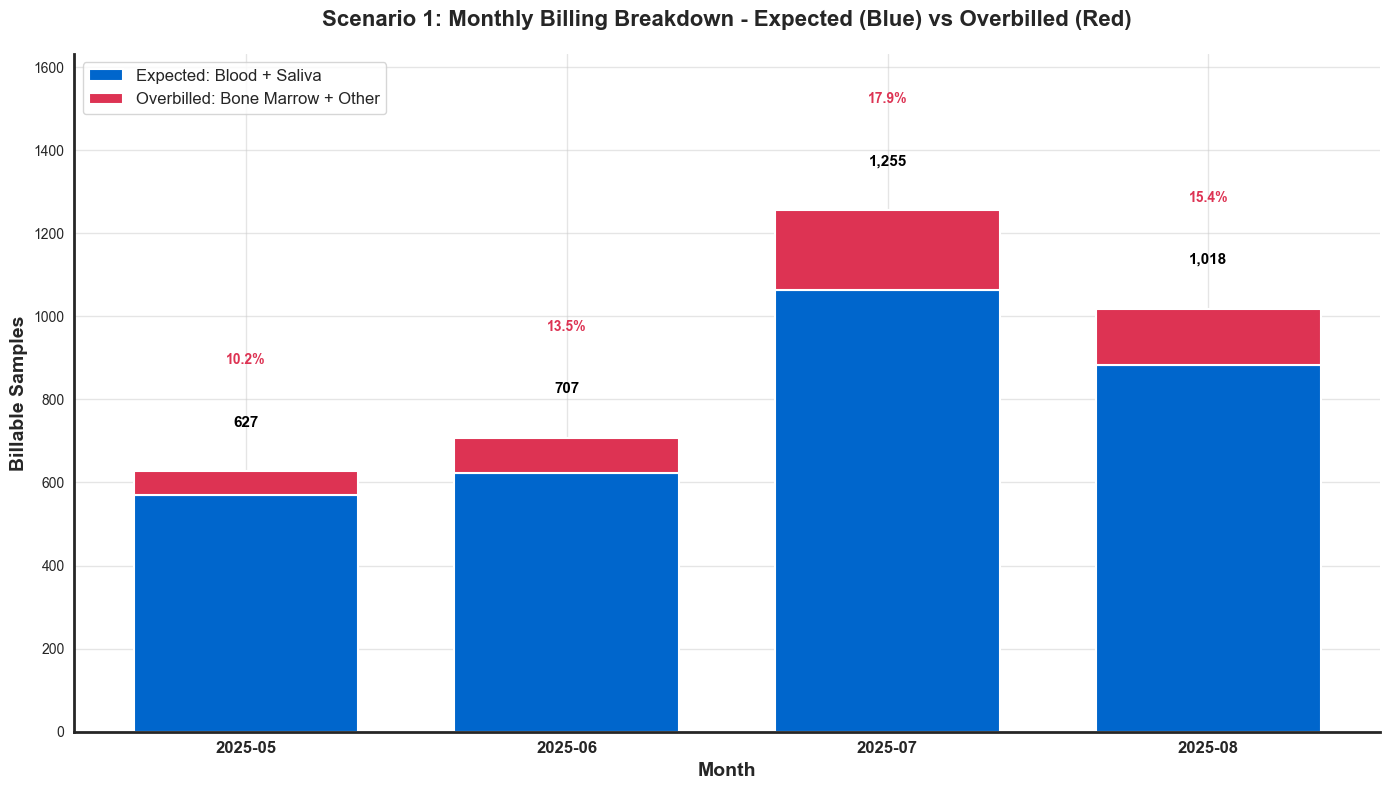

In [9]:
# Scenario 1 - Visual 2: Monthly Billing Trend
# What we're showing: Expected vs actual billing breakdown over time
# Why: Demonstrates the issue is systemic, not isolated to one month

if 'monthly' not in locals() or monthly.empty:
    print("Run previous cells first.")
else:
    visual2_monthly_trend(monthly)


In [10]:
billable_live["SAMPLE_TYPE"].value_counts().sum(), billable_live.shape, billable_live.QC_CHECK.value_counts()

(np.int64(3606),
 (3607, 16),
 QC_CHECK
 pass    3607
 Name: count, dtype: int64)

In [11]:
billable_live[billable_live["SAMPLE_TYPE"].isna()]

,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,WORKFLOW_NAME,WORKFLOW_TYPE,ENVIRONMENT_x,ID,OUTCOME,ENVIRONMENT_y,START_TIME,YEAR_MONTH
1529,e90341df-9f61-40de-9ed9-8086e0f310cd,e1d300b7-f77a-4e14-972e-71ade00b0f31,2025-07-11 12:01:57.053,haemonclabno,NaN,23297846.00,NaN,pass,[ARCHIVED] Pre-PCR - DNA Extraction V3.3,maestro,archived,e90341df-9f61-40de-9ed9-8086e0f310cd,finished,live,2025-07-11 10:39:59.166,2025-07


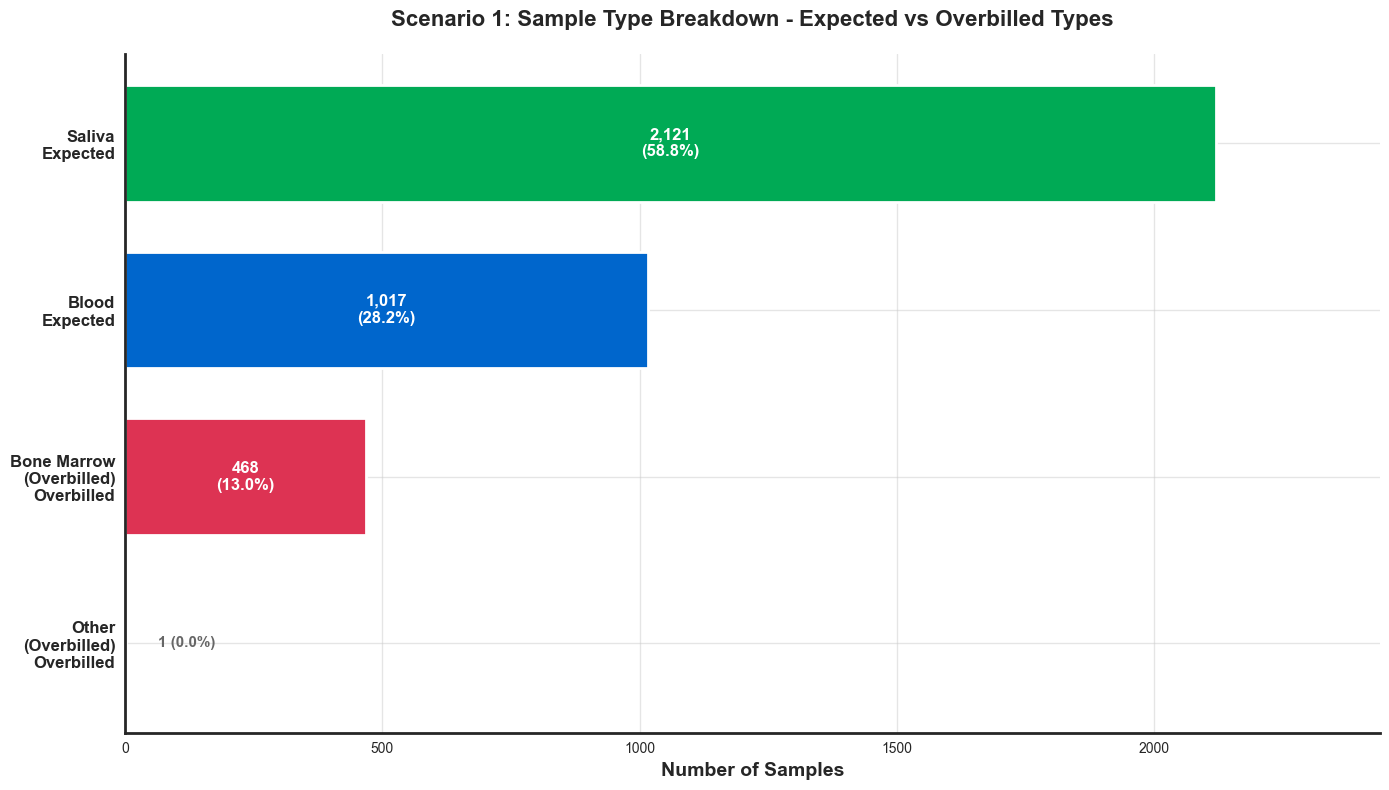

In [12]:
# Scenario 1 - Visual 3: Sample Type Breakdown
# What we're showing: What types of samples are being billed (expected vs overbilled)
# Why: Clearly separates expected (blood/saliva) from overbilled (bone marrow/other)

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    visual3_sample_types(billable_live)

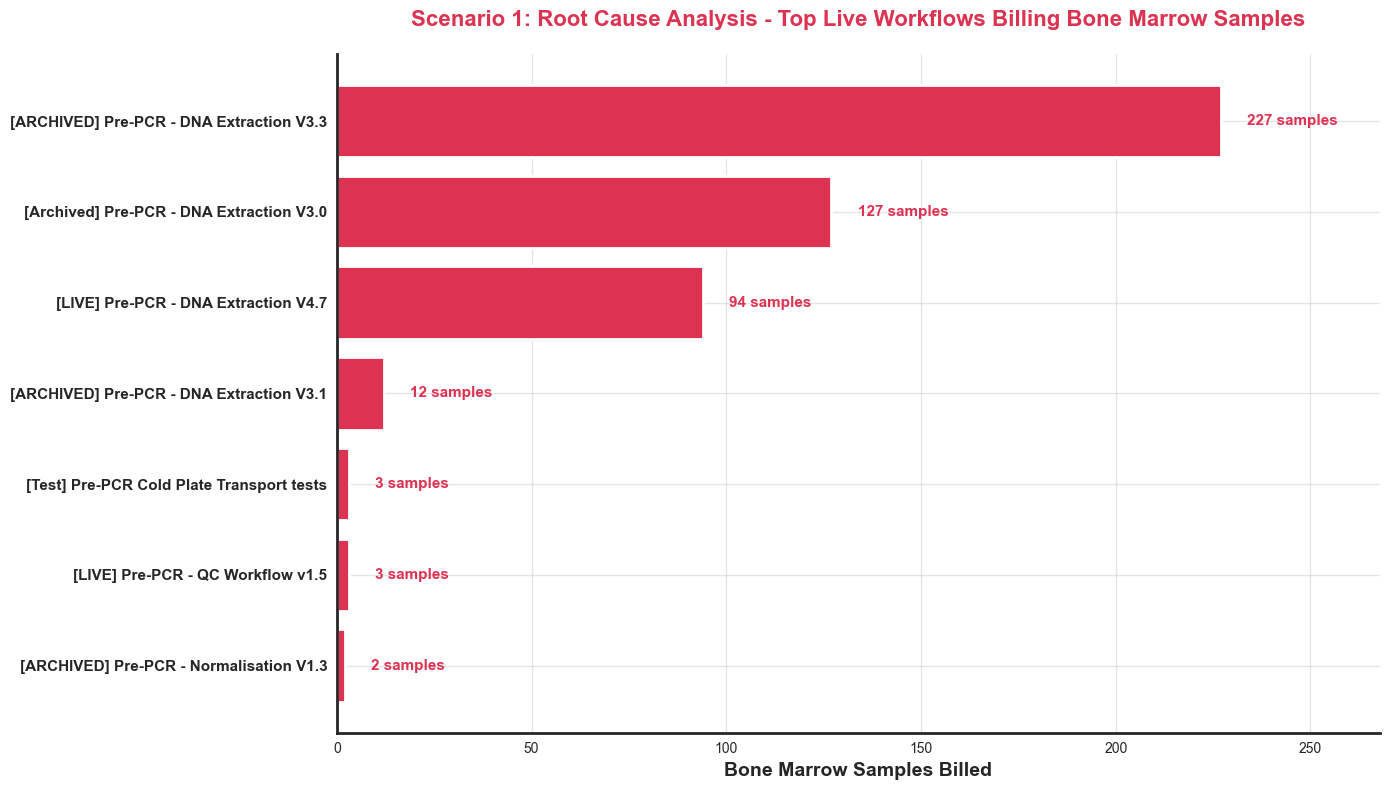

In [13]:
# Scenario 1 - Visual 4: Root Cause Analysis
# What we're showing: Which specific workflows are causing the overbilling problem
# Why: Provides actionable information (which workflows to fix) and shows concentration of the problem

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    visual4_root_cause(billable_live)

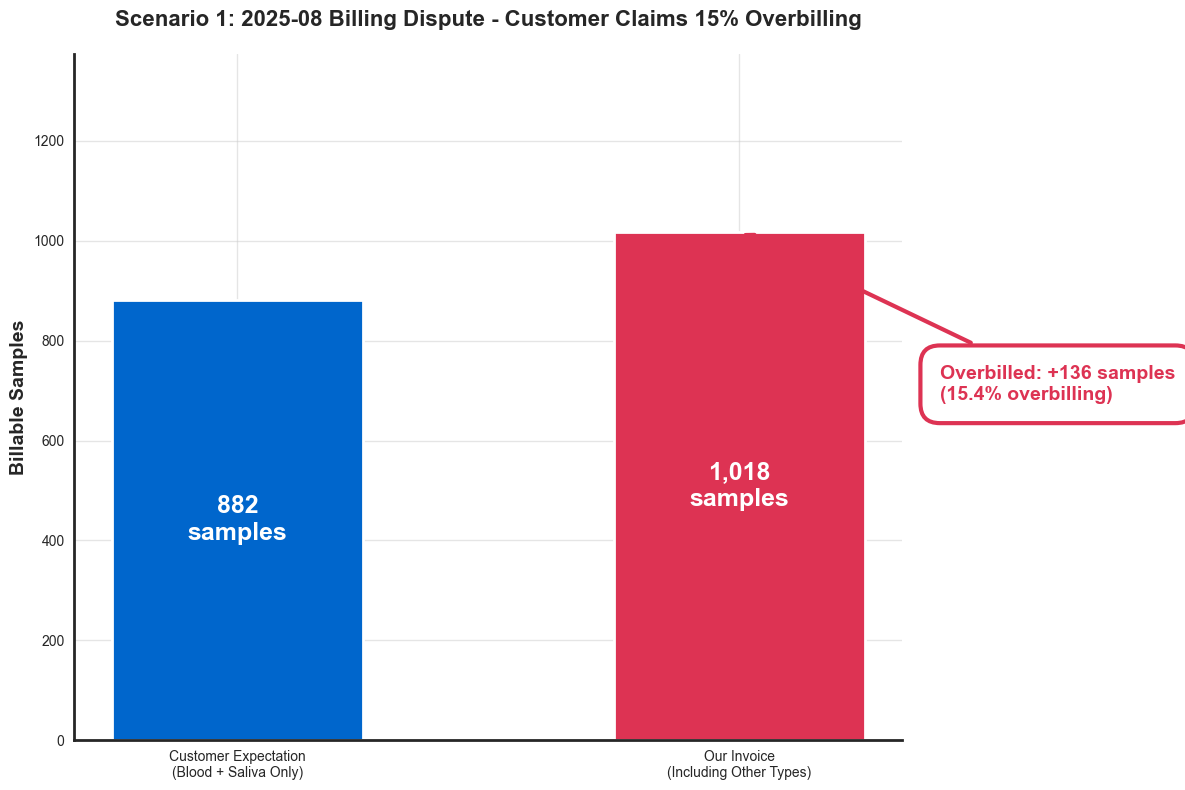

In [14]:
# Scenario 1 - Visual 1: The Billing Dispute (Executive Summary)
# What we're showing: The core dispute - customer expectation vs actual invoice
# Why: Immediately shows the problem at a glance for stakeholders

if 'billable_live' not in locals() or billable_live.empty or 'monthly' not in locals() or monthly.empty:
    print("Run the Scenario 1 metrics cell first.")
else:
    visual1_billing_dispute(monthly, billable_live)


## Scenario 2 – Customer Health: Narrative

- **What we measure**  
  - Focus on **live, finished, billable** samples (same definition as Scenario 1).  
  - Monthly view of billable sample volume and number of unique production runs.  
  - Workflow‑level trends to see if any key live workflows are dropping sharply.

- **Overall monthly usage trend (live billable)**  
  - 2025‑05: 627 billable samples (13 live runs).  
  - 2025‑06: 707 billable samples (11 runs), **+12.8%** vs May.  
  - 2025‑07: 1,255 billable samples (22 runs), **+77.5%** vs June.  
  - 2025‑08: 1,019 billable samples (18 runs), **−18.8%** vs July.

- **Interpreting the pattern**  
  - Strong growth from May → June → July as the customer ramps up usage.  
  - In August there is a **single significant drop (~19%)** relative to July, but volume is still **higher than in May/June**.  
  - On a 3‑month moving average basis, the last 3 months (Jun–Aug) are still **~15% higher** than the previous 3‑month window, so overall usage remains on an upward trajectory.

- **Workflow‑level health**  
  - We compare the last two months’ volume per live workflow.  
  - Workflows with >20% decline are flagged.  
  - In this data, the workflows with large declines between July and August are marked as **`[ARCHIVED]`**, suggesting that they are being intentionally phased out rather than indicating a healthy live workflow falling away.

- **Risk assessment**  
  - **Short‑term risk:** August’s ~19% drop is a warning sign and worth monitoring, especially if the customer has seasonality or known external drivers.  
  - **Medium‑term risk:** Because the 3‑month average is still above the previous period and declines are concentrated in archived workflows, the customer does **not yet** look like they are systematically churning away from the platform.  
  - **Action:**  
    - Monitor billable volume by month and by key live workflows for the next 1–2 months.  
    - If further consecutive declines occur, treat the account as **at‑risk** and engage proactively (e.g. review operational issues, success rates, backlog).



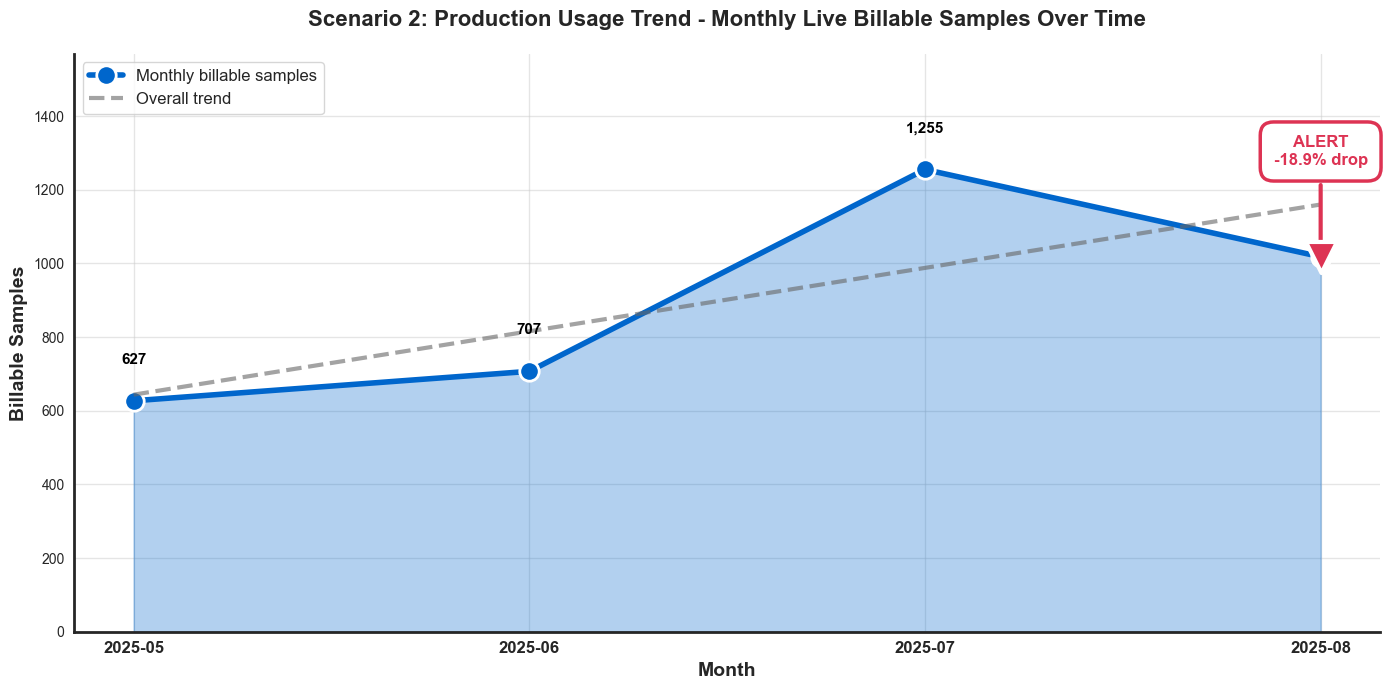

In [15]:
# Scenario 2 - Visual 1: Customer Usage Trend Over Time
# What we're showing: Monthly billable samples with trend line, highlighting significant drops
# Why: Shows overall growth trajectory and identifies concerning drops that exceed risk threshold

if 'billable_live' not in locals() or billable_live.empty:
    print("Run Scenario 1 cells first.")
else:
    visual1_usage_trend(billable_live)

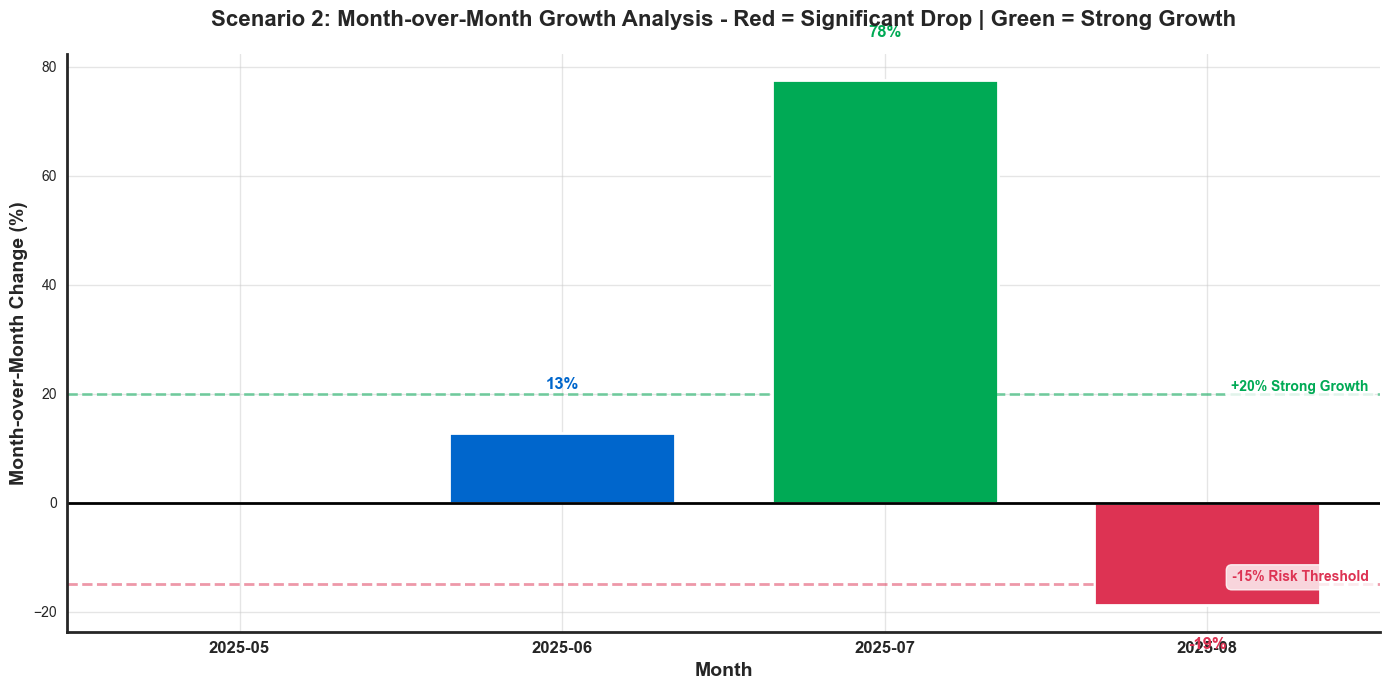

In [16]:
# Scenario 2 - Visual 2: Month-over-Month Growth Rate
# What we're showing: Month-over-month percentage change in billable samples
# Why: Highlights significant drops and growth periods to identify trends

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    visual2_mom_growth(billable_live)

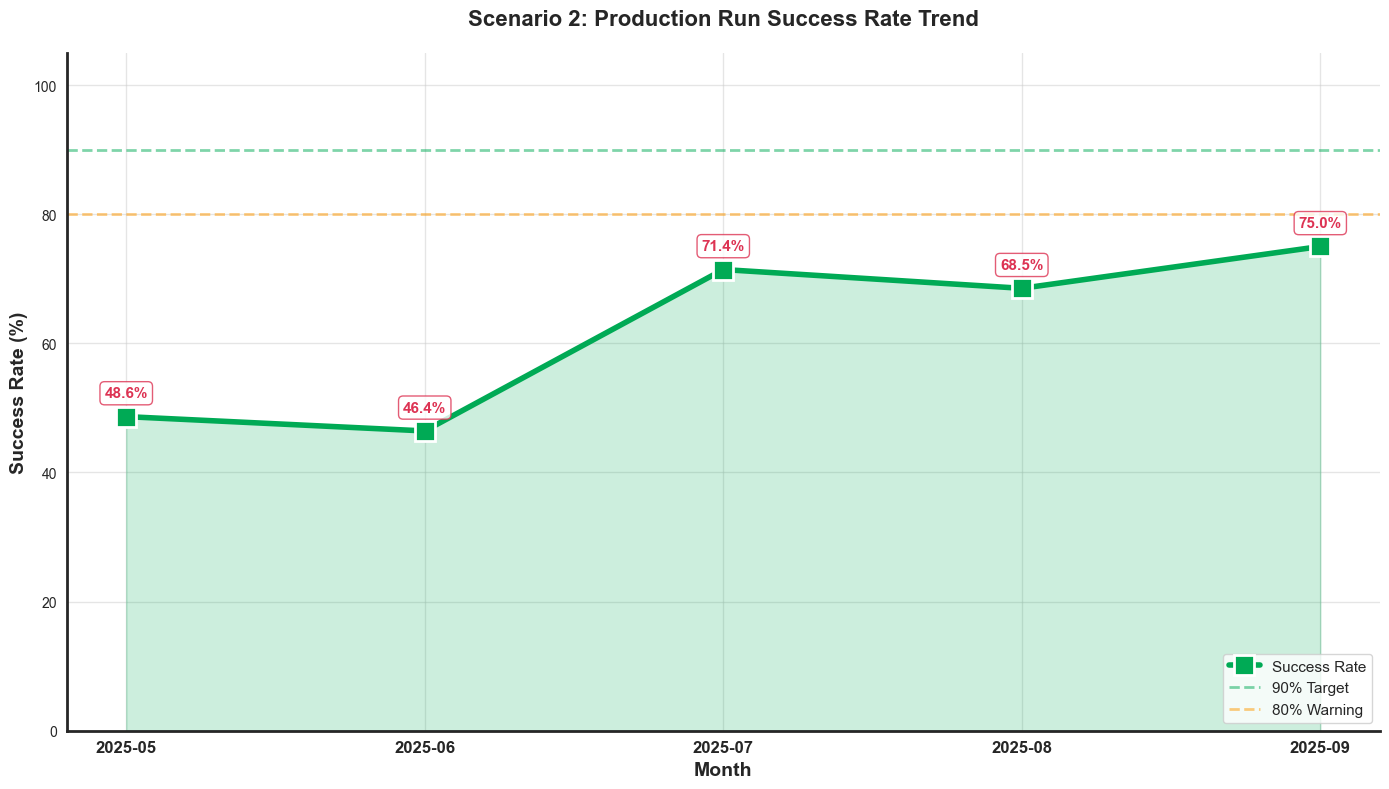

In [17]:
# Scenario 2 - Visual 3: Production Run Success Rate
# What we're showing: Success rate trend over time and breakdown of run outcomes
# Why: Operational quality is a key indicator of customer satisfaction and risk

if 'df_runs' not in locals() or df_runs.empty:
    print("Run previous cells first.")
else:
    visual3_success_rate(df_runs)


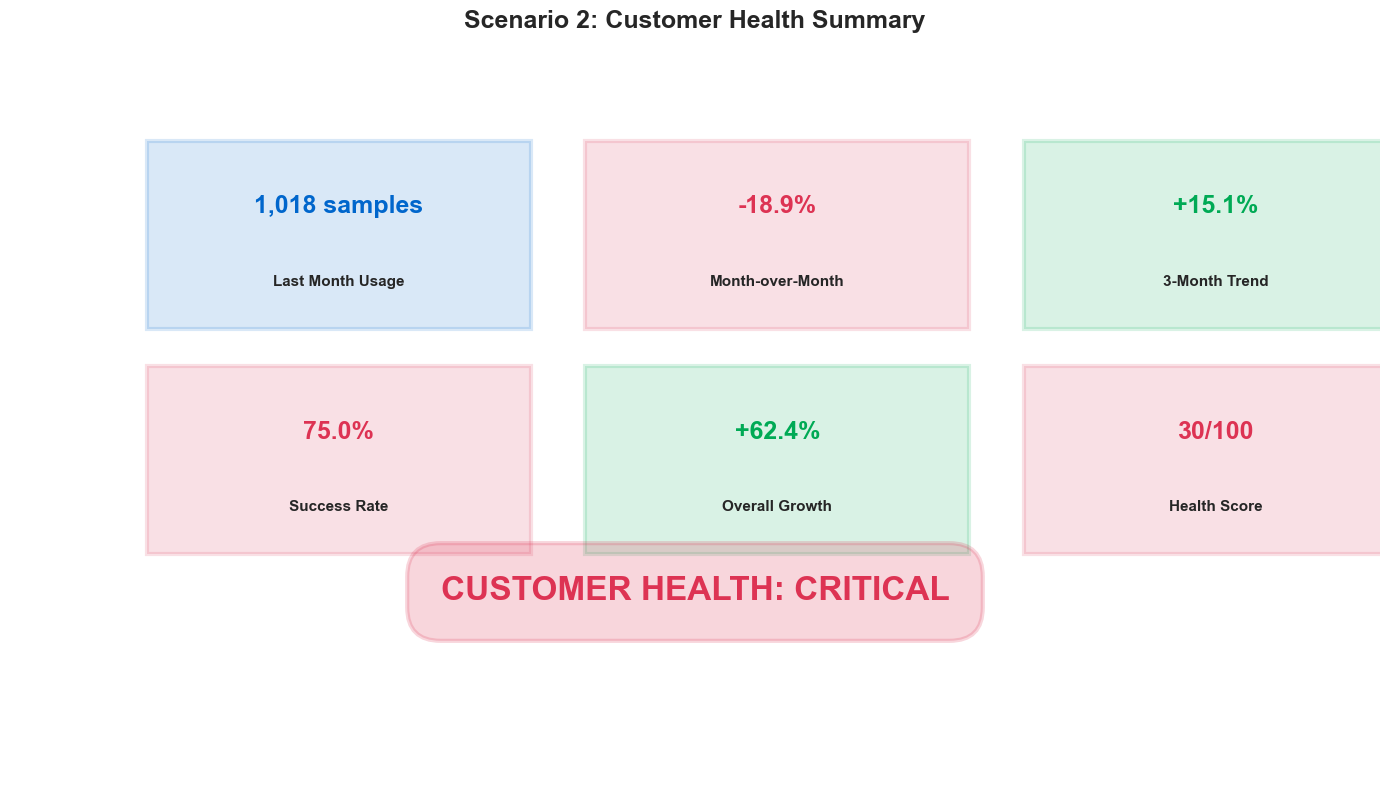

In [18]:
# Scenario 2 - Visual 4: Customer Health Scorecard
# What we're showing: Comprehensive health score combining usage, growth, and quality metrics
# Why: Provides an at-a-glance assessment of overall customer health and risk level

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    visual4_health_summary(billable_live, df_runs)